In [41]:
from bs4 import BeautifulSoup
import requests as req
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emoji
import re
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, LSTM, Dense, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
import pymorphy2
import seaborn as sns
from catboost import CatBoostClassifier

In [42]:
with open('messages_vodnyi(1).html', 'rb') as h1, open('messages_vodnyi(2).html', 'rb') as h2, open('messages_vodnyi(3).html', 'rb') as h3, open('messages_zd(1).html', 'rb') as h4, open('messages_zd(2).html', 'rb') as h5, open('messages_zd(3).html', 'rb') as h6, open('messages_spb(1).html', 'rb') as h7, open('messages_spb(1).html') as h8:
    index1 = h1.read()
    index2 = h2.read()
    index3 = h3.read()
    index4 = h4.read()
    index5 = h5.read()
    index6 = h6.read()
    index7 = h7.read()
    index8 = h8.read()

soup1 = BeautifulSoup(index1, 'html.parser')
soup2 = BeautifulSoup(index2, 'html.parser')
soup3 = BeautifulSoup(index3, 'html.parser')
soup4 = BeautifulSoup(index4, 'html.parser')
soup5 = BeautifulSoup(index5, 'html.parser')
soup6 = BeautifulSoup(index6, 'html.parser')
soup7 = BeautifulSoup(index7, 'html.parser')
soup8 = BeautifulSoup(index8, 'html.parser')


s1 = BeautifulSoup("", 'html.parser')
s1.append(soup1)
s1.append(soup2)
s1.append(soup3)

s2 = BeautifulSoup("", 'html.parser')
s2.append(soup4)
s2.append(soup5)
s2.append(soup6)


s3 = BeautifulSoup("", 'html.parser')
s3.append(soup7)
s3.append(soup8)

In [43]:
# Ищем только те посты где написан текст, заменя тэги на пробел, чтобы не было слияний
text1 = [i.get_text(" ", strip=True) for i in s1.find_all('div', class_='text')]
text2 = [i.get_text(" ", strip=True) for i in s2.find_all('div', class_='text')]
text3 = [i.get_text(" ", strip=True) for i in s3.find_all('div', class_='text')]

In [44]:
# Функция удаления всех эмодзи из текста с заменой на пустую строку
def replace_emoji(t):
    return emoji.replace_emoji(t, replace='')
# Функция для удаления лишнего из текста
def reg(t):
    t = re.sub(r'[\xa0\u200e\u200b]', '', t)
    t = re.sub(r'@\S+|#\w+', '', t) # Удаление упоминаний пользователей (начинающихся с символа @) и хэштегов (начинающихся с символа #) из текста.
    t = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', '', t) # Удаление адресов электронной почты из текста.
    t = re.sub(r'\d+', '', t) # Удаление цифр из текста..
    t = re.sub(r'[^\w\s]','', t) # Удаление знаков пунктуации из текста.
    t = re.sub(r'http\S+|https\S+', '', t) # Удаление ссылок на веб-страницы (URL) из текста.
    return t
# Собираем датафрейм
df1 = pd.DataFrame({'text': text1, 'id': 0})# 0 - водный
df2 = pd.DataFrame({'text': text2, 'id': 1})# 1 - жд
df3 = pd.DataFrame({'text': text3, 'id': 2})# 2 - транспорт санкт-петербурга

df1 = df1[:1200]
df2 = df2[:1200]
df3 = df3[:1200]
df = pd.concat([df1, df2, df3], ignore_index=True)

print(df)

# Применяем наши функции
df['text'] = df['text'].apply(lambda x: str(x))
df['text'] = df['text'].apply(replace_emoji)
df['text'] = df['text'].apply(reg)
df['text'] = df['text'].apply(lambda x: x.lower())

# Удаление стопслов
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
df


                                                   text  id
0                     Водный транспорт г. Москвы ⛴ ⚓️ 🛟   0
1     ❗ Появилась схема развития речного транспорта ...   0
2     ❗ Появилась схема развития речного транспорта ...   0
3     ❗️ Напоминаем, что с 1 сентября проезд на элек...   0
4     🌊 Вот это популярность: ежедневно на электросу...   0
...                                                 ...  ..
2997  В Петербурге за полгода нанесут свыше 737 тыся...   2
2998  Петербургский автохудожник показал, как можно ...   2
2999  Новые ограничения: Петербург продолжает замедл...   2
3000  Поймай Пушкина: петербуржцам предложили поучас...   2
3001  Лето пришло, удобство ушло: «Удельная» и «Фрун...   2

[3002 rows x 2 columns]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,id
0,водный транспорт г москвы,0
1,появилась схема развития речного транспорта мо...,0
2,появилась схема развития речного транспорта мо...,0
3,напоминаем сентября проезд электросудне стоить...,0
4,это популярность ежедневно электросудах соверш...,0
...,...,...
2997,петербурге полгода нанесут свыше тысяч квадрат...,2
2998,петербургский автохудожник показал сочетать ра...,2
2999,новые ограничения петербург продолжает замедля...,2
3000,поймай пушкина петербуржцам предложили поучаст...,2


In [45]:
# Пропущенные значения
df = df.drop_duplicates()
df.isnull().sum()

text    0
id      0
dtype: int64

In [46]:
# Баланс классов
df['id'].value_counts()

id
1    1198
0    1083
2     346
Name: count, dtype: int64

In [47]:
# Токенизируем и лемматизируем текст
morph = pymorphy2.MorphAnalyzer()
df['text'] = df['text'].apply(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in x.split()]))
print(df['text'])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
X = tokenizer.texts_to_sequences(df['text'])


maxlen = df['text'].apply(lambda x: len(x.split())).max()
X = pad_sequences(X, maxlen=maxlen)
print(X)

<ipython-input-47-228997a33f75>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in x.split()]))


0                               водный транспорт г москва
1       появиться схема развитие речной транспорт моск...
2       появиться схема развитие речной транспорт моск...
3       напоминать сентябрь проезд электросудно стоить...
4       это популярность ежедневно электросуд совершат...
                              ...                        
2649    петербург полгода нанести свыше тысяча квадрат...
2650    петербургский автохудожник показать сочетать р...
2651    новый ограничение петербург продолжать замедля...
2652    поймать пушкин петербуржец предложить поучаств...
2653    лето прийти удобство уйти удельный фрунзенский...
Name: text, Length: 2627, dtype: object
[[   0    0    0 ...   28  194    8]
 [   0    0    0 ... 8573 8574  237]
 [   0    0    0 ...  159   41   44]
 ...
 [   0    0    0 ...  540 1178  768]
 [   0    0    0 ... 3926 1547 1707]
 [   0    0    0 ...  221  325   14]]


In [48]:
c = list(df['id'].values)
e = LabelEncoder()
e.fit(c)
y = e.transform(c)
y

array([0, 0, 0, ..., 2, 2, 2])

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128),
    LSTM(64, recurrent_dropout=0.3, return_sequences=True, dropout=0.3),
    LSTM(32, recurrent_dropout=0.3, return_sequences=True, dropout=0.3),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(units=3, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.4, callbacks=[early_stopping])

Epoch 1/15
20/20 [==============================] - 40s 2s/step - loss: 1.3407 - accuracy: 0.4452 - val_loss: 1.2556 - val_accuracy: 0.4518
Epoch 2/15
20/20 [==============================] - 32s 2s/step - loss: 1.2217 - accuracy: 0.5175 - val_loss: 1.1309 - val_accuracy: 0.7848
Epoch 3/15
20/20 [==============================] - 31s 2s/step - loss: 0.9923 - accuracy: 0.7619 - val_loss: 0.8435 - val_accuracy: 0.8240
Epoch 4/15
20/20 [==============================] - 34s 2s/step - loss: 0.7551 - accuracy: 0.8063 - val_loss: 0.6492 - val_accuracy: 0.8312
Epoch 5/15
20/20 [==============================] - 31s 2s/step - loss: 0.6384 - accuracy: 0.8278 - val_loss: 0.5762 - val_accuracy: 0.8383
Epoch 6/15
20/20 [==============================] - 31s 2s/step - loss: 0.5467 - accuracy: 0.8413 - val_loss: 0.5058 - val_accuracy: 0.8514
Epoch 7/15
20/20 [==============================] - 34s 2s/step - loss: 0.4494 - accuracy: 0.8865 - val_loss: 0.4466 - val_accuracy: 0.9037
Epoch 8/15
20/20 [==

In [57]:
# Оценка модели на тестовом наборе данных
loss_test, acc_test = model.evaluate(X_test, y_test)

# Оценка модели на обучающем наборе данных
loss_train, acc_train = model.evaluate(X_train, y_train)

# Предсказание классов на тестовом наборе
predictions = model.predict(X_test)

# Преобразование вероятностных предсказаний в классы
predicted_classes = np.argmax(predictions, axis=1)

# Вычисление метрик качества: precision, recall, f1-score
precision_test = precision_score(y_test, predicted_classes, average='weighted')
recall_test = recall_score(y_test, predicted_classes, average='weighted')
f1_score_test = f1_score(y_test, predicted_classes, average='weighted')

# Вывод результатов
print(f'Точность на обучающем наборе данных: {acc_train}, Точность на тестовом наборе данных: {acc_test}')
print(f'Precision на тестовом наборе: {precision_test}')
print(f'Recall на тестовом наборе: {recall_test}')
print(f'F1-score на тестовом наборе: {f1_score_test}')

17/17 [==============================] - 4s 222ms/step
Точность на обучающем наборе данных: 0.9747739434242249, Точность на тестовом наборе данных: 0.946768045425415
Precision на тестовом наборе: 0.9543473588483116
Recall на тестовом наборе: 0.9467680608365019
F1-score на тестовом наборе: 0.9489095747871206


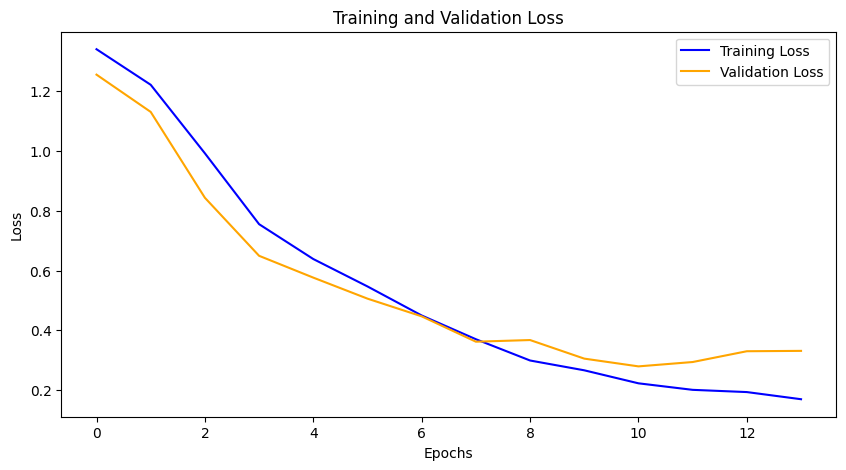

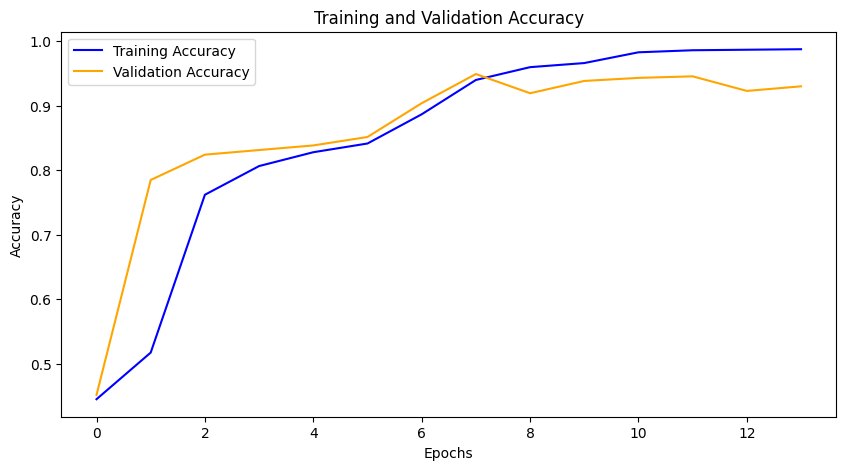

In [50]:
def plot_training_history(history):
    # Получаем значения функции потерь и точности на обучающем и валидационном наборах
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Строим график функции потерь
    plt.figure(figsize=(10, 5))
    plt.plot(loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Строим график точности
    plt.figure(figsize=(10, 5))
    plt.plot(accuracy, label='Training Accuracy', color='blue')
    plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Пример использования
plot_training_history(history)

17/17 [==============================] - 3s 152ms/step


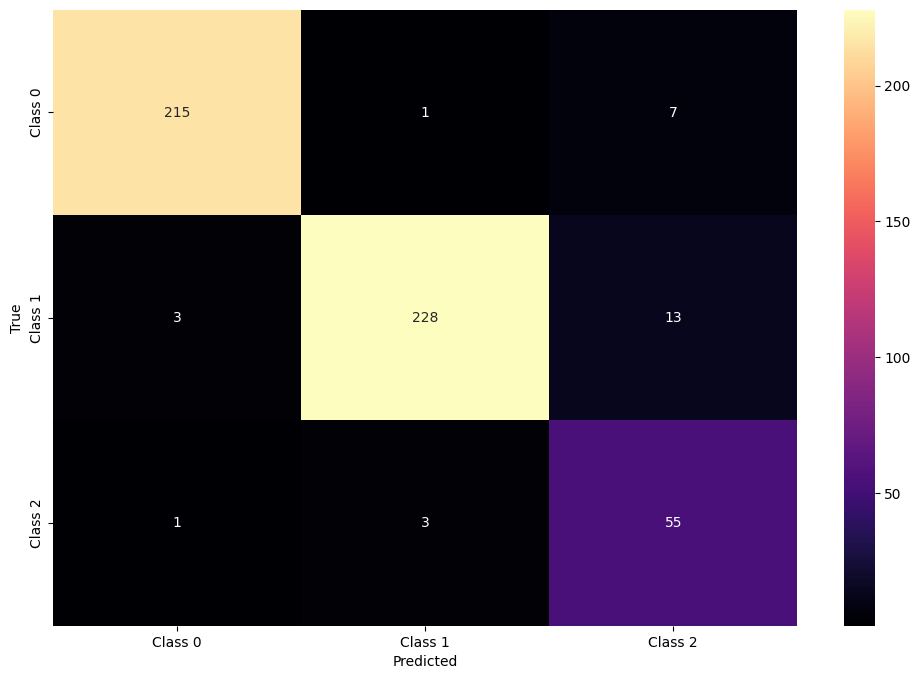

In [51]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Создание матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Визуализация матрицы ошибок с помощью seaborn
class_names = ['Class 0', 'Class 1', 'Class 2']
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="magma", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [56]:
class_names = ['водный', 'железнодорожный', 'транспорт Санкт-Петербурга']

def clear_t(text):
    text = replace_emoji(text)
    text = text.lower()
    text = reg(text)
    text = ' '.join([morph.parse(word)[0].normal_form for word in text.split()])
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text_sequence = tokenizer.texts_to_sequences([text])
    text_sequence = pad_sequences(text_sequence, maxlen=maxlen)
    return text_sequence

def predict_and_print_class(model, text, class_names):
    text = clear_t(text)
    predict_proba = model.predict(text)
    predict_class = np.argmax(predict_proba)
    print(f"Предсказанный класс: {class_names[predict_class]}")
    print(f"Вероятности классов: {predict_proba}")

new_text = "Как сообщает ГУП Петербургский метрополитен, в связи с капитальным ремонтом эскалаторов с 13 мая по 23 августа 2024 года по рабочим дням недели изменяется режим работы наземного вестибюля станции Звёздная (Линия 2, Московско-Петроградская): с 7:45 до 9:00 часов вход в вестибюль ограничен."
predict_and_print_class(model, new_text, class_names)

new_text1 = "Водные объекты Нижегородской области будут включены в федпроект «Вода России»"
predict_and_print_class(model, new_text1, class_names)

new_text2 = "В ночь на 6 июня в чешском городе Пардубице пассажирский поезд лоб в лоб столкнулся с товарным. Погибло 4 человека. 34 человека получили ранения."
predict_and_print_class(model, new_text2, class_names)


1/1 [==============================] - 0s 95ms/step
Предсказанный класс: транспорт Санкт-Петербурга
Вероятности классов: [[0.08339185 0.09838359 0.81822455]]
1/1 [==============================] - 0s 88ms/step
Предсказанный класс: водный
Вероятности классов: [[0.7793579  0.09860057 0.12204152]]
1/1 [==============================] - 0s 89ms/step
Предсказанный класс: железнодорожный
Вероятности классов: [[0.02128435 0.8683654  0.11035021]]


Learning rate set to 0.093866
0:	learn: 0.5916230	test: 0.5893536	best: 0.5893536 (0)	total: 115ms	remaining: 2m 52s
250:	learn: 0.8871966	test: 0.7699620	best: 0.7737643 (232)	total: 13.8s	remaining: 1m 8s
500:	learn: 0.9614469	test: 0.7927757	best: 0.8003802 (431)	total: 27.7s	remaining: 55.3s
750:	learn: 0.9861970	test: 0.7851711	best: 0.8003802 (431)	total: 41.6s	remaining: 41.5s
1000:	learn: 0.9952404	test: 0.7832700	best: 0.8003802 (431)	total: 55.8s	remaining: 27.8s
1250:	learn: 0.9990481	test: 0.7870722	best: 0.8003802 (431)	total: 1m 9s	remaining: 13.9s
1499:	learn: 1.0000000	test: 0.7908745	best: 0.8003802 (431)	total: 1m 24s	remaining: 0us

bestTest = 0.8003802281
bestIteration = 431

Shrink model to first 432 iterations.


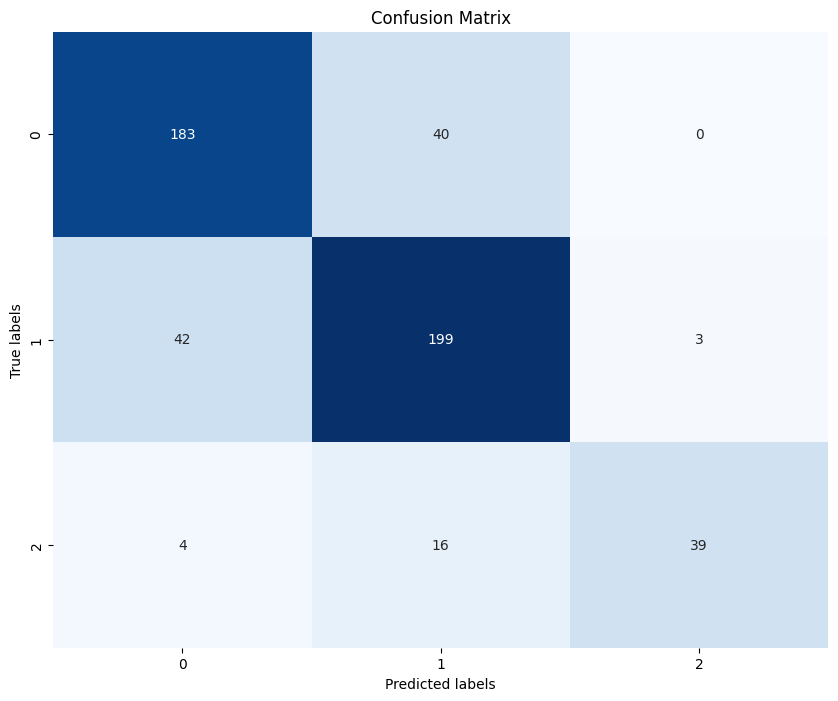

Precision - test: 0.804955590750754
Recall - test: 0.8003802281368821
F1-score - test: 0.7999018618797079
Accuracy - test: 0.8003802281368821


In [39]:
# Создание и обучение модели
model = CatBoostClassifier(iterations=1500, depth=5, eval_metric='Accuracy', loss_function='MultiClass')
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=250)

# Предсказание на тестовом наборе данных
y_pred = model.predict(X_test)

# Вычисление и вывод матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Вывод результатов
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)
print(f'Precision - test: {precision}')
print(f'Recall - test: {recall}')
print(f'F1-score - test: {f1}')
print(f'Accuracy - test: {accuracy}')